In [1]:
import sys
sys.path.insert(1, '../')


In [2]:
import importlib
import medical_explainer
importlib.reload(medical_explainer)


<module 'medical_explainer' from '/Users/ahsueh/Documents/GA Tech/BD4H/Uni-ACS/mimiciv_sepsis_mortality/../medical_explainer.py'>

In [3]:
import pandas as pd
data = pd.read_csv('mimiciv_sepsis.csv').drop(['testtrain', 'hadm_id'], axis=1)

data['gender'] = data['gender'].apply(lambda x: 1 if x == 'M' else 0)

data = pd.concat([data, pd.get_dummies(data['marital_status'], prefix='marital_status')], axis=1)
data = data.drop(['marital_status'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ethnicity'], prefix='ethnicity')], axis=1)
data = data.drop(['ethnicity'], axis=1)

data = pd.concat([data, pd.get_dummies(data['insurance'], prefix='insurance')], axis=1)
data = data.drop(['insurance'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ed_medgp_antibiotic_hrgp'], prefix='antibiotic')], axis=1)
data = data.drop(['ed_medgp_antibiotic_hrgp'], axis=1)


In [4]:
from sklearn.model_selection import train_test_split

seed = 7

X = data.drop(['icu_adm_flag', 'hosdeath_flag'], axis=1)
y = data['hosdeath_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)


In [5]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression

estimators = [('Scaler', StandardScaler()), ('Log_Reg', LogisticRegression(random_state=seed, solver='liblinear'))]
pipe = Pipeline(estimators)

clf = pipe.fit(X_train, y_train)


| Step 1  ==> Calibrating model


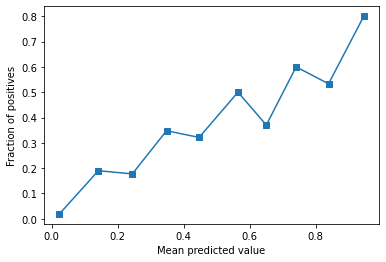

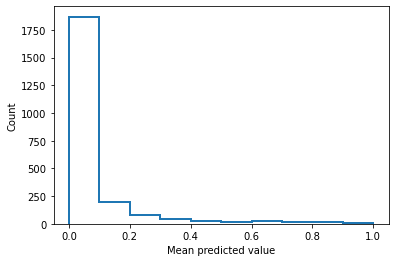

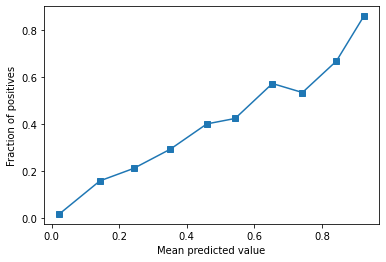

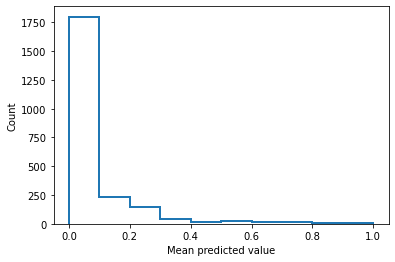

ROC AUC: 0.8820026662716635
Average Precision: 0.4157228149040318
Accuracy: 0.9332466406588643
ROC AUC: 0.882152273737224
Average Precision: 0.4149705085801185
Accuracy: 0.9349804941482445

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


Probability threshold: 0.1
Score threshold: 54.0

Probability threshold: 0.5
Score threshold: 76.0

Probability threshold: 0.9
Score threshold: 80.0



In [8]:
explainer = medical_explainer.explainer(
    clf, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='linear', method='novel')

In [13]:
scores,probs,predictions = explainer.predict_calculator(X_test, 1)

In [14]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

# accuracy = accuracy_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

# print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, predictions))


ROC AUC: 0.784489705228855
Average Precision: 0.21295946170085833
Accuracy: 0.9319462505418292
[[2150    0]
 [ 157    0]]


# Classic LogReg

In [59]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

# Select top 10 features for fair comparison
top_n = 10

scaler = MinMaxScaler()
select = SelectKBest(chi2, k=top_n)
select.fit(scaler.fit_transform(X_train), y_train)
# selected_features = select.get_feature_names_out(X_train.columns)
temp = np.argsort(-select.scores_)
selected_features = X_train.columns[temp[:top_n]]

In [60]:
from pygam import LogisticGAM, s, f

equation = s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + f(7) + f(8) + f(9)

gam = LogisticGAM(equation).fit(X_train[selected_features], y_train)

In [61]:
import medical_explainer_classic
importlib.reload(medical_explainer_classic)

explainer_classic = medical_explainer_classic.explainer(
    X_train, y_train, X_test, y_test
)

| Step 1 ==> Selecting top n features
| Step 2 ==> Transforming features based on GAM
| Step 3 ==> Fitting logistic regression model on transformed categories
| Step 4 ==> Calibrating logistic regression model


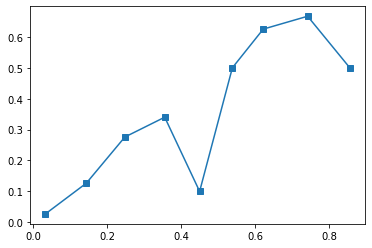

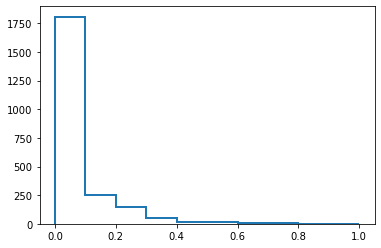

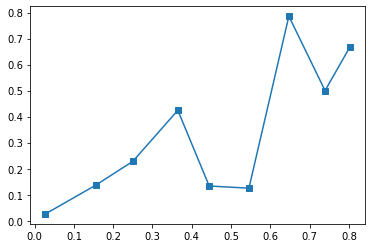

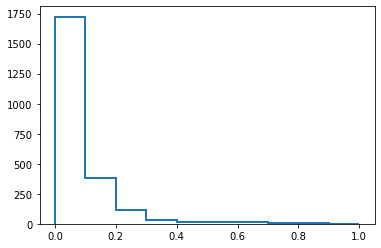

| Step 5 ==> Fit clinical score calculator
Fit clincal score calculator
Threshold:0.1
4

Threshold:0.5
9

Threshold:0.9
14



In [62]:
from sklearn.model_selection import StratifiedKFold

print('| Step 1 ==> Selecting top n features')
explainer_classic.selected_features = selected_features

print('| Step 2 ==> Transforming features based on GAM')
explainer_classic.find_features_categories_gam(equation)

print('| Step 3 ==> Fitting logistic regression model on transformed categories')
explainer_classic.fit_logreg()

print('| Step 4 ==> Calibrating logistic regression model')

skf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

explainer_classic.plot_calibration_original()
explainer_classic.calibrate(cv=skf)
explainer_classic.plot_calibration_calibrated()

print('| Step 5 ==> Fit clinical score calculator')
explainer_classic.fit_calculator()

In [49]:
scores_classic,probs_classic,predictions_classic = explainer_classic.predict_calculator(X_test, 1)

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

roc_curve_orig = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
roc_curve_learner = roc_curve(y_test, probs)
roc_curve_classic = roc_curve(y_test, probs_classic)

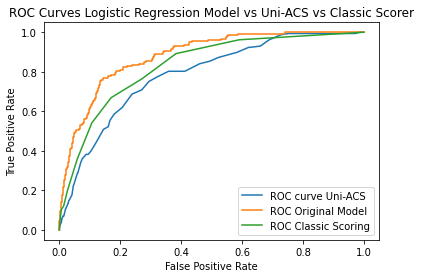

In [52]:
plt.plot(roc_curve_learner[0], roc_curve_learner[1], label="ROC curve Uni-ACS")
plt.plot(roc_curve_orig[0], roc_curve_orig[1], label="ROC Original Model")
plt.plot(roc_curve_classic[0], roc_curve_classic[1], label="ROC Classic Scoring")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Logistic Regression Model vs Uni-ACS vs Classic Scorer")
plt.legend(loc="lower right")

plt.savefig('Logistic_roc.png')